In [1]:
import torch
import torchvision as tv
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(0)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# now visualize the embedding space
@torch.no_grad()
def compute_embeddings(model, dataloader, times=float("inf")):
	latents = []
	labels = []
	times_acc = 0
	for i, (b_img, b_labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
		if times_acc >= times:
			break
		
		_, latent, _, _, _ = model(b_img.view(-1, 784))
		latents.extend(latent.tolist())
		labels.extend(b_labels.tolist())

		times_acc += 1

	return torch.tensor(latents), torch.tensor(labels)


def custom_legend(colors, labels):
	fig, ax = plt.subplots()
	fig.set_figwidth(15)
	fig.set_figheight(1)
	ax.bar(labels, [1 for i in range(len(labels))], label=labels, color=colors)
	return ax

def plot_mnist(latents, labels):
	tab10 = ["#5778a4", "#e49444", "#d1615d", "#85b6b2", "#6a9f58", "#e7ca60", "#a87c9f", "#f1a2a9", "#967662", "#b8b0ac"]
	custom_legend(tab10, [str(i) for i in range(10)])
	plt.show()
	plt.figure(figsize=(16, 9))
	plt.scatter(latents[:, 0], latents[:, 1], c=[tab10[i] for i in labels.tolist()], s=2, alpha=1)

In [3]:
mnist_train = tv.datasets.MNIST(root='./data', train=True, download=True, transform=tv.transforms.ToTensor())
train = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)

In [5]:
def reparameterize(mean: torch.Tensor, log_var: torch.Tensor):
    """
    `mean` as μ 
    `log_var` as log(σ^2)
    """
    std_dev = torch.exp(0.5*log_var)    # σ = e^(log(σ^2)/2)
    eps = torch.randn_like(mean)        # ε ~ N(0, I)
    z = mean + eps*std_dev              # z = μ + σ*ε

    return z
    
class VAE(nn.Module):
    def __init__(self, flat_input_dim=784, latent_dims=2):
        super().__init__()

        # encoder 
        self.enc_hidden1 = nn.Linear(flat_input_dim, 256)
        self.enc_hidden2 = nn.Linear(256, 128)
              
        self.enc_mu = nn.Linear(128, latent_dims)
        self.enc_log_var = nn.Linear(128, latent_dims)

        # decoder
        self.dec_hidden1 = nn.Linear(latent_dims, 128)
        self.dec_hidden2 = nn.Linear(128, 256)
        self.dec_recon = nn.Linear(256, flat_input_dim)
        
    def forward(self, x):
        """Assumes input of x is normalized between [0, 1] instead of [0, 255]"""

        # encode
        h1 = torch.relu(self.enc_hidden1(x))
        h2 = torch.relu(self.enc_hidden2(h1))

		# variational shit
        mean = self.enc_mu(h2)
        log_var = self.enc_log_var(h2)
        latent = reparameterize(mean, log_var)

        # decode
        h3 = torch.relu(self.dec_hidden1(latent))
        h4 = torch.relu(self.dec_hidden2(h3))
        recon = torch.sigmoid(self.dec_recon(h4)) # back to what x looks like

        # compare x to the reconstruction
        latent_loss = -0.5*torch.sum(1 + log_var - mean**2 - torch.exp(log_var)**2, dim=-1)
        latent_loss = torch.mean(latent_loss, dim=0)
        recon_loss = torch.sum((recon-x)**2, dim=-1)
        recon_loss = torch.mean(recon_loss, dim=0)
        loss = recon_loss + latent_loss

        return recon, latent, recon_loss, latent_loss, loss

  0%|          | 0/469 [00:00<?, ?it/s]

100%|██████████| 469/469 [00:16<00:00, 28.80it/s]


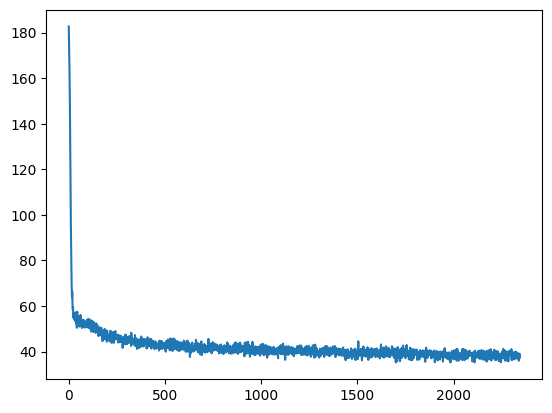

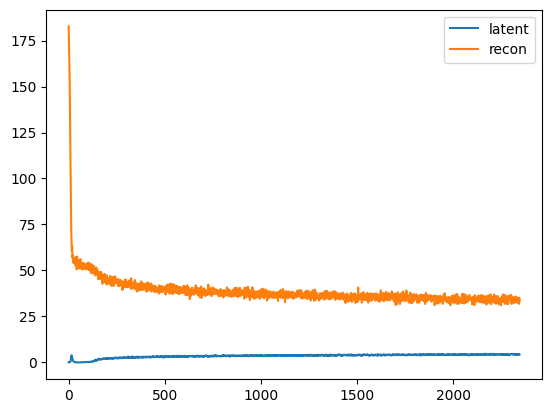

In [6]:
model_bigger = VAE(latent_dims=2)
optim = torch.optim.AdamW(model_bigger.parameters(), lr=1e-3)
epochs = 5
losses = []
recon_losses = []
latent_losses = []
for i in range(epochs):
	for b_img, _ in tqdm(train):
		optim.zero_grad()

		# forward pass
		_, _, recon_loss, latent_loss, loss = model_bigger(b_img.view(-1, 784))

		# backward pass and update
		loss.backward()
		optim.step()
		losses.append(loss.item())
		recon_losses.append(recon_loss.item())
		latent_losses.append(latent_loss.item())

plt.plot(losses)
plt.show()
plt.plot(latent_losses, label="latent")
plt.plot(recon_losses, label="recon")
plt.legend()

100%|██████████| 469/469 [00:08<00:00, 56.19it/s]


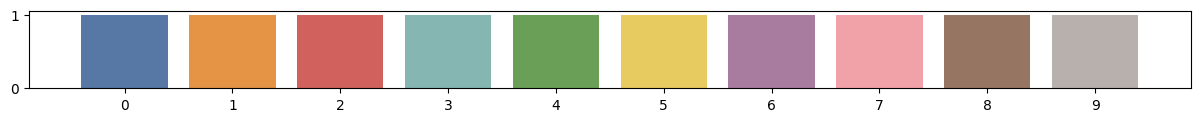

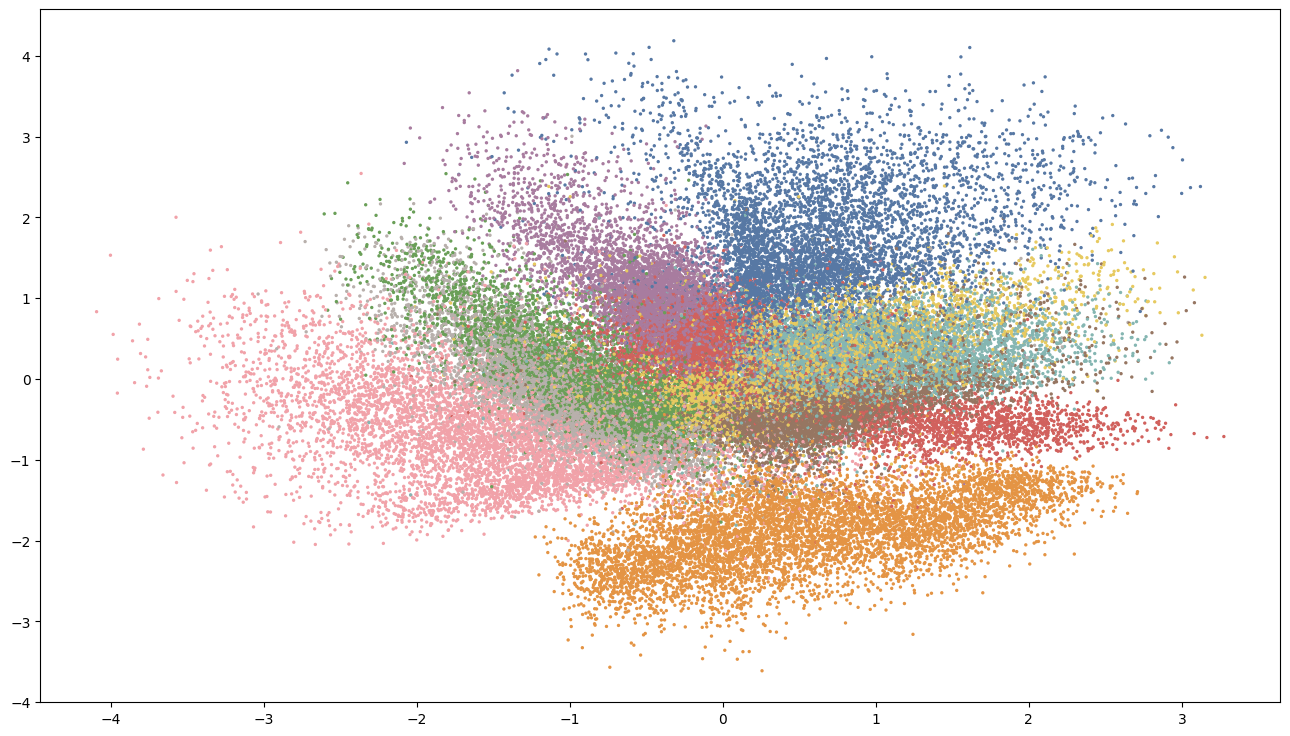

In [8]:
latents, labels = compute_embeddings(model_bigger, train)
plot_mnist(latents, labels)